# Analysis 2
Jana Bruses | janabruses@pitt.edu | University of Pittsburgh | Apr 21st - ...

Second notebook of the Analysis portion of the project.\
First notebook found at: [Analysis-1-LowLevel](http://localhost:8888/notebooks/Linguistic-Markers-Catalan-Substitution/Analysis-1-LowLevel.ipynb)\
Fourth notebook of the project, after the [data portion](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Data-Parsing-Exploratory-Analysis-2.ipynb) notebook.

In this analysis notebook various machine learning models were used to analyze the effectiveness of the selected linguistic markers that could indicate Catalan's substitution explored in [Analysis-1-LowLevel](http://localhost:8888/notebooks/Linguistic-Markers-Catalan-Substitution/Analysis-1-LowLevel.ipynb) namely:\
"hi" percentage - to analyze loss of word classes\
passat perifràstic vs passat simple - to analyze time lexicon modification\
anar vs venir percentage - to analyze space lexicon modification\
haver de vs tenir que percentage - to analyze  syntactic Restructuring\
verb pronominalization - to analyze syntactic Restructuring

Contents on this analysis notebook:\
**1 Supervised learning**\
**A** Building a Naïve Bayes classifier using tf-idf features (pre-post Franquism)\
**B** Building a Naïve Bayes classifier using tf-idf features (3 period)\
**C** Building a classifier using our linguistic features\
**2 Clustering (not concluded)**\
Getting time clusters according to our linguistic features

In [2]:
# loading libraries
import pandas as pd
import numpy as np

All the data used in the analysis steps was included in the dataframe and pickled at the end of the analysis.\
The data will now be loaded.

In [3]:
# loading the pickled complete dataframe
tokscomplete_df = pd.read_pickle("data/tokcomplete_df.pkl")
tokscomplete_df = tokscomplete_df.drop_duplicates(subset="Text", keep="first")

## 1. Supervised Machine Learning

### A. Tf-Idf Naive Bayes for pre vs post Franquism

Our data, is split in two main periods, before Franquism and after Franquism. We have two blocks of data. From 1860 to 1926 and from 1985 to 2022. We will label this two periods as 1926b and 1985a and have a classifier distinguish them, to look for other features trough tf-idf, that could tell us more about Catalan's substitution.

In [4]:
def period2_tagger(year):
    if year <= 1926:
        return "1926b"
    elif year >= 1985:
        return "1985a"
    else:
        print(year) #printing any years not in that range to check

In [5]:
tokscomplete_df["Period2"] = tokscomplete_df["Year"].apply(period2_tagger)

In [6]:
tokscomplete_df["Period2"].value_counts()

Period2
1985a    64916
1926b       28
Name: count, dtype: int64

**Comment:**
As this numbers portray, we have a huge amount of data for the recent period, while we have very few documents for the period from 1926 and earler. However, since these are ceremonial speeches, looking at the length in tokens might actually be more informative. 

In [7]:
tokscomplete_df.groupby("Period2")["Len_toks"].sum()

Period2
1926b     143831
1985a    2803938
Name: Len_toks, dtype: int64

**Comment:** The gap is not as big as it was looking at file counts, as many of the later contributions are shorter, containing fewer tokens, while the few documents from before 1926 are complete speeches. 

Because of this, instead of having the classifier classify full pieces of text, we will use single sentences as the text features. 

In [8]:
def sent_tokenize(content):
    doc = nlp(content)
    sent_list = [sentence.text for sentence in doc.sentences]
    return sent_list

Since sentence tokenization through Stanza is a very demanding process that my laptop couldn't handle it was done using the pitt's CRC supercomputing. The following commented code corresponds to the files, using a very similar process as the function sent_tokenize above. The files in their respective extension can be found in [Scripts Folder](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/tree/main/scripts) as "sent_tok.py" and "sent_tok.sh".

In [9]:
python_code = """
import pandas as pd
import stanza

data_df = pd.read_pickle("lemmaComplete.pkl")
nlp = stanza.Pipeline(lang='ca', processors='tokenize')
mini_doc = nlp("Hola, com estas? Jo genial. I tu? Anem a fer una volta?")
print("sentences list:")
print([sent.text  for
        sent in nlp(mini_doc).sentences])
print()

data_df["Sent_toks"] = data_df["Text"].apply(lambda doc:
                                                        [sent.text  for
                                                        sent in nlp(doc).sentences])
data_df.to_pickle("sent_tok.pkl")
"""

In [10]:
slurm_file = """
#!/usr/bin/env bash

#SBATCH --job-name=proj_senttok
#SBATCH --output=sent_tok.out
#SBATCH --nodes=1
#SBATCH --ntasks=3
#SBATCH --partition=smp
#SBATCH --cluster=smp
#SBATCH --mem-per-cpu=16000
#SBATCH --time=180

module load python/ondemand-jupyter-python3.11
python sent_tok.py
"""

In [11]:
# reading the pickled dataframe with the new column containing the sentence tokens 
senttok_df = pd.read_pickle("data/sent_tok.pkl")

In [12]:
# looking at a couple examples
sent_tokens_example = senttok_df[senttok_df["Year"] == 1860]["Sent_toks"].iloc[0]
print(sent_tokens_example[0])
print()
print(sent_tokens_example[1])

Breu seré, cuant ja se han complagut vostres oídos ab los melodiosos cants de tants trovadors inspirats per lo esperit de la Religió, per lo amor de la patria y per lo amor á la bellesa ¿Qué podria jo anyadir cuant sento ja escapar de mon esperit la última espurna del juvenil entusiasme?

Tant sols me cap lo expressar ab curtas frases lo goig que inunda mon cor al véurervos per segona vegada reunits en aquesta festa de familia, renovant memorias tan dolsas, evocant noms tan estimats, y recordant dias tan gloriosos pera nostra antiga patria.


In [13]:
# re-doing the period tag on the sentence tokenized dataframe
senttok_df["Period2"] = senttok_df["Year"].apply(period2_tagger)

In [14]:
senttok_df["Sent_count"] = senttok_df["Sent_toks"].apply(lambda sents: len(sents))

In [15]:
senttok_df.groupby("Period2")["Sent_count"].sum()

Period2
1926b      2835
1985a    199697
Name: Sent_count, dtype: int64

In [16]:
# considering the total
senttok_df["Sent_count"].sum()

202532

In [17]:
# basline is incredibly high
199697/202532

0.986002211996129

**Comment:** We have a very big imbalance. One of the target groups of the 2 accounts for 98% of the data, which means that even if we tagged everything as that group, specifically "1985a" we would get 98% accuracy. Consequently, our classifier will need to be almost perfect either 99% or completely perfect to do better than the baseline.

In [18]:
# creating a function to tag the sentences
def tag_sents(sent_list, period2_tag):
    return ([(s, period2_tag) for s in sent_list])

In [19]:
# tagging the sentences
senttok_df["tagged_sents"] = senttok_df.apply(lambda row: tag_sents(row["Sent_toks"], row["Period2"]), axis=1)

In [20]:
# separating them into two lists
sents_1926b = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="1926b"]
sents_1985a = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="1985a"]

In [21]:
# checking a sentence from each of the lists to see the tag
print(sents_1926b[0])
sents_1985a[0]

("L'home que per amor al estudi, impulsat per un imperatiu ineludible 's manté reclòs en el seu laboratori o en la biblioteca, treballant sense parar may, indiferent a les temptacions mondanes, es certament un hèroe.", '1926b')


('perquè que el president de catalunya sigui rebut pel president de la comissió europea',
 '1985a')

In [22]:
# concatenating the two tagged sentence lists
sents = sents_1926b+sents_1985a

# randomizing the lists after concatenation
import random
random.Random(10).shuffle(sents)

In [23]:
# turning the tagged sents lists into a dataframe
tagged_df = pd.DataFrame(sents, columns=["sentence", "tag"])

In [24]:
# creating traning and testing partitions
from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(tagged_df["sentence"], tagged_df["tag"], test_size = 0.20, random_state = 0)

In [25]:
# examining resulting partitions 
print(len(docs_train), len(docs_test))
print(len(y_train), len(y_test))
print()
print(sorted(set(y_train)))
print(sorted(set(y_test)))

162025 40507
162025 40507

['1926b', '1985a']
['1926b', '1985a']


In [26]:
import sklearn
from sklearn.pipeline import make_pipeline

# for Naïve Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# will consist of 2 steps
# step 1: feature extraction through tf-idf
# step 2: naive bayes multinomial model
period2_nbc = make_pipeline(TfidfVectorizer(max_features = 1500), MultinomialNB())

# fitting and training model through pipeline 
period2_nbc.fit(docs_train, y_train) # fitting model (training sents, target labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=1500)),
                ('multinomialnb', MultinomialNB())])

In [27]:
# creating predicted labels
y_pred_prompt_nb = period2_nbc.predict(docs_test)

In [28]:
# evaluating
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [29]:
# checking accuracy score
accuracy_score(y_test, y_pred_prompt_nb)

0.9908904633767003

**Comment:** The performance is slightly better than if we just tagged everything as the most likely tag from the baseline which is 1985a. It has an accuracy of 99% compared to the baseline of 98%, which means that the tf-idf features do in fact help the classifier tag sentences as belonging to before 1926 or after 1985. 

Let's now take a look at where the errors are with a confusion matrix:

<function matplotlib.pyplot.show(close=None, block=None)>

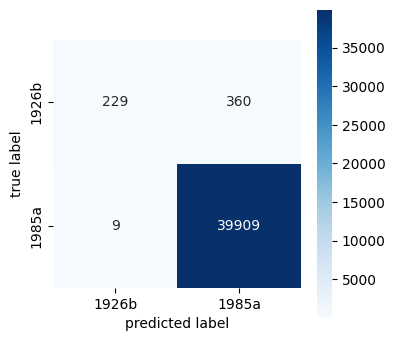

In [30]:
import matplotlib.pyplot as plt
mtrx_prompt_nb = confusion_matrix(y_test, y_pred_prompt_nb)
# plotting confusion matrix
plt.figure(figsize = (4, 4))
sns.heatmap(mtrx_prompt_nb, square = True, annot = True, fmt = 'd', cmap = "Blues", 
            xticklabels= sorted(set(y_train)), yticklabels= sorted(set(y_pred_prompt_nb)))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show

**Comment:** It seems like there are only 9 out of 39918 sentences that have been wrongly tagged as texts from after 1985 that were written before, which means that only 2 out of every 100 sentences are wrongly tagged into the after 1985 group but were written before 1925.\
For sentences written before 1926 out of 589 sentences 229 were wrongly tagged as written after 1985. This is about 38% of the sentences.\
This results are not surprising considering that we had a lot more sentences from the later period to train the classifier with.\
However, this matrix allows us to see why the model outperformed what tagging according to the baseline would give us. In that case all 39918 sentences written after 1985 would have been correctly tagged, so the 2% error wouldn't be present. However, none of the 589 sentences written before 1926 would have been correcly tagged, making it a bit worse in accuracy than the Naive Bayes classification with Tf-idf features. 

In [31]:
# how to take a look at the features

### B. Tf-Idf Naive Bayes for 3 period classification

Next we will try to break down the time periods in smaller periods so that the baseline is not as high.

In [32]:
# looking were to break down the second, more data-extensive period
np.median([2022, 1985])

2003.5

**Comment:** Since we had a lot more data in the second period we will now break down the second and most recent time period in 2 shorter periods right down the median which is 2003.5, so we will do from 1985 to 2003 and from 2004 until 2022. We will kepp the period from before 1926 as a single time period.

In [33]:
# breaking down our data in:
# before 1926 (inclusive), between 1985 and 2004 (not ending inclusive), after 2004 (inclusive)
def period3_tagger(year):
    if year <= 1926:
        return "old"
    elif year >= 1985 and year < 2004:
        return "mid"
    elif year >= 2004:
        return "recent"
    else:
        print(year) #printing any years not in that range to check

In [34]:
senttok_df["Period3"] = senttok_df["Year"].apply(period3_tagger)

In [35]:
# tagging the sentences
senttok_df["tagged_sents"] = senttok_df.apply(lambda row: tag_sents(row["Sent_toks"], row["Period3"]), axis=1)

In [36]:
# creating a function to tag the sentences
def tag_sents(sent_list, period3_tag):
    return ([(s, period3_tag) for s in sent_list])

In [37]:
# separating them into two lists
sents_old = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="old"]
sents_mid = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="mid"]
sents_recent = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="recent"]

In [38]:
sents_recent[0]

('perquè que el president de catalunya sigui rebut pel president de la comissió europea',
 'recent')

In [39]:
# concatenating the two tagged sentence lists
sents = sents_old+sents_mid+sents_recent

# randomizing the lists after concatenation
import random
random.Random(10).shuffle(sents)

# turning the tagged sents lists into a dataframe
tagged_df = pd.DataFrame(sents, columns=["sentence", "tag"])

# creating traning and testing partitions
from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(tagged_df["sentence"], tagged_df["tag"], test_size = 0.20, random_state = 0)

# examining resulting partitions 
print(len(docs_train), len(docs_test))
print(len(y_train), len(y_test))
print()
print(sorted(set(y_train)))
print(sorted(set(y_test)))

162025 40507
162025 40507

['mid', 'old', 'recent']
['mid', 'old', 'recent']


In [40]:
# will consist of 2 steps
# step 1: feature extraction through tf-idf
# step 2: naive bayes multinomial model
period3_nbc = make_pipeline(TfidfVectorizer(max_features = 1500), MultinomialNB())

# fitting and training model through pipeline 
period3_nbc.fit(docs_train, y_train) # fitting model (training sents, target labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=1500)),
                ('multinomialnb', MultinomialNB())])

In [41]:
senttok_df.groupby("Period3")["Sent_count"].sum()

Period3
mid         3393
old         2835
recent    196304
Name: Sent_count, dtype: int64

In [42]:
# considering the total
senttok_df["Sent_count"].sum()

202532

In [43]:
# basline is still extremly high
196304/202532

0.9692493038137183

In [44]:
# creating predicted labels
y_pred_prompt_nb = period3_nbc.predict(docs_test)

# checking accuracy score
accuracy_score(y_test, y_pred_prompt_nb)

0.9762510183425087

<function matplotlib.pyplot.show(close=None, block=None)>

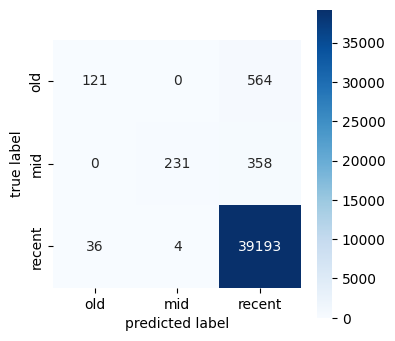

In [45]:
import matplotlib.pyplot as plt
mtrx_prompt_nb = confusion_matrix(y_test, y_pred_prompt_nb)
# plotting confusion matrix
plt.figure(figsize = (4, 4))
sns.heatmap(mtrx_prompt_nb, square = True, annot = True, fmt = 'd', cmap = "Blues", 
            xticklabels= ("old", "mid", "recent"), yticklabels= ("old", "mid", "recent"))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show

It seems like while the model makes errors labeling recent sentence that we wouldn't make if we just labeled every sentence as "recent" as it is the most likely sentence with a 96.9%, misslaveling 2% of the recent sentences on the test set, the improvement in the "baseline performance" is in how the middle period and old sentences are tagged. There are no misslabels between mid and old sentences, which suggests that dividing the periods in the two groups cutting at 1926 and 1985 was the right point as the 2 groups "old" and "mid" are clearly differnciable. The biggest issue I find is that there are more misslabels between old and recent sentences both ways than between recent and mid any of the 2 ways, which suggests that mid and recent senetences are not as similar as I expected them to be and can indeed be better separated into two periods than I would I have thought. Hence, they don't really belong to the same period.
This 3 period devision model outperformed the previous 2 period model as it is closer to the 1% improvement from the baseline. 

### Building a classifier using our linguistic features

Since our goal for this project is to see if the specific features can help us evaluate language substitution and we've looked for specific features, instead of using the tf-idf features, we will now use the percentages of these linguistic features as the features for time-period classification.

Also, since the 3 period classifier outperformed the 2 period one, we will now work with the same 3 periods. That is:\
Old - before 1926\
Mid - 1985-2003\
Recent - 2004-2022

In [46]:
# loading the complete dataframe
complete_df = pd.read_pickle("data/complete_df.pkl")

In [47]:
complete_df["tag3"]=complete_df["Year"].apply(period3_tagger)

In [48]:
# starting with 3 period division as it outperformed the 2 period division classification
from sklearn.model_selection import train_test_split
feat_train, feat_test, y_train, y_test = train_test_split(complete_df["Anar_percent"], complete_df["tag3"], test_size = 0.20, random_state = 0)

In [49]:
# examining resulting partitions 
print(len(feat_train), len(feat_test))
print(len(y_train), len(y_test))
print()
print(sorted(set(y_train)))
print(sorted(set(y_test)))

9674908 2418728
9674908 2418728

['mid', 'old', 'recent']
['mid', 'old', 'recent']


In [50]:
period3_nbc = make_pipeline(MultinomialNB())

In [51]:
feat_train = feat_train.values.reshape(-1, 1)
feat_test = feat_test.values.reshape(-1, 1)

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
clf = RandomForestClassifier(class_weight='balanced')

In [54]:
clf.fit(feat_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [55]:
# creating predicted labels
y_pred_prompt3_rf = clf.predict(feat_test)

# checking accuracy score
accuracy_score(y_test, y_pred_prompt3_rf)

0.24747718635580354

<function matplotlib.pyplot.show(close=None, block=None)>

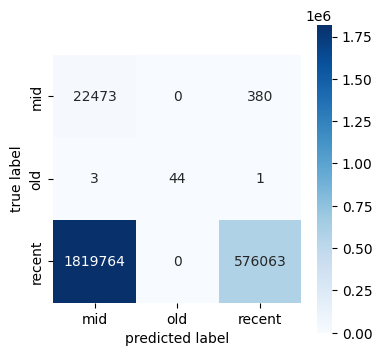

In [56]:
import matplotlib.pyplot as plt
mtrx_prompt_nb = confusion_matrix(y_test, y_pred_prompt3_rf)
# plotting confusion matrix
plt.figure(figsize = (4, 4))
sns.heatmap(mtrx_prompt_nb, square = True, annot = True, fmt = 'd', cmap = "Blues", 
            xticklabels= ("mid", "old", "recent"), yticklabels= ("mid", "old", "recent"))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show

**Conclusions:**\
Even though the model only gets 24.5% accuracy, what matters more to me isn’t that overall score — it’s how the errors are distributed. Right away, you can tell the model is mostly guessing between “recent” and “old”, and is basically ignoring the “mid” class. Out of 451 actual “mid” examples, it only predicts 44 correctly. That’s a clear sign that the model isn’t learning what defines the middle period — maybe because it’s underrepresented or less distinctive.

The biggest confusion happens between “recent” and “old” — over 1.8 million sentences labeled “recent” are classified as “old.” That’s surprising, since I expected those two to be more distinguishable. On the other hand, there’s barely any confusion between “mid” and “old” (just 3 cases), which tells me that even though the model struggles to recognize “mid,” at least it doesn’t mistake it for “old.”

So the model is picking up on some signal to separate “old” from everything else, but it doesn’t really know what to do with “mid,” and defaults to calling it “recent.” Overall, the Random Forest doesn’t perform well, but the pattern of its mistakes confirms that having three periods makes sense — I just need to handle the class imbalance better if I want “mid” not to disappear.

## Clustering
Next to see if the linguistic features we analyzed are valuable or not we will try to find year clusters or time divisions for each of the features. However, since we want the clusters to be a continuous period (eg.: we don't want 1860 and 1867 to be clustered together if 1865 belongs to another cluster) we will need to use **Ward hierarchical clustering** as it allows for connectivity constraints.
The following Clustering process has been done following:\
[Scikit-learn User Guide 2.3. on Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)\
[DataCamp's Introduction to Hierarchical Clustering](https://www.datacamp.com/tutorial/introduction-hierarchical-clustering-python)\
[DataCamp's Cluster Analysis in Python](https://app.datacamp.com/learn/courses/cluster-analysis-in-python)

In [57]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12093636 entries, 0 to 12093635
Data columns (total 29 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Year              int64  
 1   Line_id           object 
 2   Text              object 
 3   Text_len          int64  
 4   toks              object 
 5   Len_toks          int64  
 6   toks_low          object 
 7   hi                object 
 8   -hi               object 
 9   hi_count          int64  
 10  hi_percent        float64
 11  Lemmas            object 
 12  Anar_count        int64  
 13  Venir_count       int64  
 14  Anar_percent      float64
 15  Venir_percent     float64
 16  PstPerif          object 
 17  Pstp_count        int64  
 18  Pstp_percent      float64
 19  HaverDe_count     int64  
 20  TenirQue_count    int64  
 21  HaverDe_percent   float64
 22  TenirQue_percent  float64
 23  POS               object 
 24  PronominalizedV   object 
 25  PronV_count       int64  
 26  V_total     

### Getting the data ready for clustering

In [58]:
# keeping only the columns we want (percentages, which are floats and a single int which is the Year (will be turned into the target)
df = complete_df[["Year", # target
                  "hi_percent", # loss of word classes
                  "Anar_percent", "Venir_percent", "Pstp_percent", # time and space lexicon modification
                  "HaverDe_percent", "TenirQue_percent", "PronV_percent"]] # syntactic restructuring

In [59]:
df.head(3)

,Year,hi_percent,Anar_percent,Venir_percent,Pstp_percent,HaverDe_percent,TenirQue_percent,PronV_percent
0,1926,0.013761,0.839411,0.027522,0.481629,0.206413,0.0,4.732824
1,1920,0.053619,0.428954,0.000000,0.214477,0.053619,0.0,10.596026
2,1900,0.006790,0.129015,0.033951,0.040741,0.122224,0.0,8.818636


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12093636 entries, 0 to 12093635
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Year              int64  
 1   hi_percent        float64
 2   Anar_percent      float64
 3   Venir_percent     float64
 4   Pstp_percent      float64
 5   HaverDe_percent   float64
 6   TenirQue_percent  float64
 7   PronV_percent     float64
dtypes: float64(7), int64(1)
memory usage: 738.1 MB


**Comment:** We have a huge amount of data that can't be used for hierarchical clustering. Therefore, we will create a sample of data and work with it from now on in this part of the analysis. 

In [61]:
# sampling data because we have too much data to work with to do hierarchical clustering
sample_data = []

for year in sorted(df['Year'].unique()):
    yearly_data = df[df['Year'] == year]
    sample = yearly_data.sample(n=min(2000, len(yearly_data)), random_state=0)
    sample_data.append(sample)

sample_data = pd.concat(sample_data)

In [62]:
sample_data.describe()

,Year,hi_percent,Anar_percent,Venir_percent,Pstp_percent,HaverDe_percent,TenirQue_percent,PronV_percent
count,39473.000000,39473.000000,39473.000000,39473.000000,39473.000000,39473.000000,39473.000000,39473.000000
mean,2000.691435,0.250702,0.624920,0.078227,0.288887,0.252776,0.000762,14.711094
std,11.285871,0.917997,1.666854,0.540368,1.120169,0.866710,0.053029,23.136820
min,1860.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1995.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2007.000000,0.000000,0.403277,0.000000,0.000000,0.000000,0.000000,22.222222
max,2022.000000,25.000000,50.000000,25.000000,25.000000,20.000000,6.521739,100.000000


In [63]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39473 entries, 204 to 4440
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              39473 non-null  int64  
 1   hi_percent        39473 non-null  float64
 2   Anar_percent      39473 non-null  float64
 3   Venir_percent     39473 non-null  float64
 4   Pstp_percent      39473 non-null  float64
 5   HaverDe_percent   39473 non-null  float64
 6   TenirQue_percent  39473 non-null  float64
 7   PronV_percent     39473 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 2.7 MB


**Comment:** Our data is remarkably smaller, with now about 22000 entries compared to the initial 12093636, and reducng its size from 738.1MB to 1.6MB.

Normally the next step would be to remove any outliers. However, in our case, that would mean throwing away most of the early years, which is not ideal since we want to look at a historical change. Therefore, we won't be removing outliers but will need to keep it in mind as it will likely squeue our data. 

Since our goal is to see how the different linguistic features cluster our data, we will normalize the data by column/feature.

In [64]:
# normalizing data per column/feature
from sklearn.preprocessing import StandardScaler

features = ["hi_percent", "Anar_percent", "Venir_percent", "Pstp_percent", "PronV_percent"]

scaler = StandardScaler()
sample_data[features] = scaler.fit_transform(sample_data[features])

In [65]:
sample_data.describe()

,Year,hi_percent,Anar_percent,Venir_percent,Pstp_percent,HaverDe_percent,TenirQue_percent,PronV_percent
count,39473.000000,39473.000000,3.947300e+04,3.947300e+04,3.947300e+04,39473.000000,39473.000000,3.947300e+04
mean,2000.691435,0.000000,5.760233e-18,1.620066e-17,5.760233e-18,0.252776,0.000762,-1.440058e-17
std,11.285871,1.000013,1.000013e+00,1.000013e+00,1.000013e+00,0.866710,0.053029,1.000013e+00
min,1860.000000,-0.273100,-3.749144e-01,-1.447688e-01,-2.578990e-01,0.000000,0.000000,-6.358385e-01
25%,1995.000000,-0.273100,-3.749144e-01,-1.447688e-01,-2.578990e-01,0.000000,0.000000,-6.358385e-01
50%,2002.000000,-0.273100,-3.749144e-01,-1.447688e-01,-2.578990e-01,0.000000,0.000000,-6.358385e-01
75%,2007.000000,-0.273100,-1.329725e-01,-1.447688e-01,-2.578990e-01,0.000000,0.000000,3.246437e-01
max,2022.000000,26.960458,2.962209e+01,4.612056e+01,2.206045e+01,20.000000,6.521739,3.686331e+00


**Comment:** Since hierarchical clustering uses Euclidean distance, which is sensitive to scale, we need to rescale all the variables before computing the distance.

In [66]:
# sorting the values and scaling the features
X = sample_data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Comment:** After scaling the data the next step is stablishing the constraint which is known as "conectivity" in Ward linkage for hyerarchical clustering. In our case, that is that **only neighboring years can be in the same cluster**, as we need to allow 1900-1901-1902 to be in the same cluster but not 1900-1902 if 1901 is in another cluster.

In [67]:
# ensuring only neighboring years can be in same cluster
# based on https://scikit-learn.org/stable/auto_examples/cluster/plot_ward_structured_vs_unstructured.html
# done through a kneighbors_graph
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X_scaled, n_neighbors=2, include_self=False)

In [68]:
import numpy as np
from scipy.sparse import csr_matrix

n_samples = X_scaled.shape[0]  # Number of years (or rows)
rows = np.arange(n_samples - 1)
cols = np.arange(1, n_samples)

# Create sparse matrix where each year is connected only to its next
connectivity = csr_matrix((np.ones(n_samples - 1), (rows, cols)), shape=(n_samples, n_samples))
connectivity = connectivity + connectivity.T  # Make it symmetric

In [69]:
sample_data

,Year,hi_percent,Anar_percent,Venir_percent,Pstp_percent,HaverDe_percent,TenirQue_percent,PronV_percent
204,1860,-0.2731,-0.374914,0.048204,-0.257899,0.260688,0.0,-0.590053
202,1860,-0.2731,-0.374914,0.048204,-0.257899,0.260688,0.0,-0.494128
200,1860,-0.2731,-0.374914,0.048204,-0.257899,0.260688,0.0,-0.574676
207,1860,-0.2731,-0.374914,0.048204,-0.257899,0.260688,0.0,-0.421072
198,1860,-0.2731,-0.374914,0.048204,-0.257899,0.260688,0.0,-0.397374
...,...,...,...,...,...,...,...,...
4438,2021,-0.2731,-0.374914,3.414102,-0.257899,0.000000,0.0,-0.635838
4405,2021,-0.2731,-0.374914,-0.144769,-0.257899,4.761905,0.0,0.228595
4402,2021,-0.2731,-0.374914,-0.144769,-0.257899,0.000000,0.0,-0.155597
4441,2022,-0.2731,-0.374914,-0.144769,-0.257899,0.000000,0.0,-0.439376


In [70]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    model = AgglomerativeClustering(n_clusters=k, connectivity=connectivity, linkage='ward')
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append((k, score))

In [71]:
scores

[(2, -0.1560226780708679),
 (3, -0.15478554244150292),
 (4, -0.167781899755033),
 (5, -0.15965765492276976),
 (6, -0.15621753759138896),
 (7, -0.15592325834457793),
 (8, -0.15196521559107287),
 (9, -0.15165981976533613)]

In [72]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(
    n_clusters=4,
    connectivity=connectivity,
    linkage="ward"
).fit(sample_data)
label = ward.labels_

In [73]:
sample_data["period_cluster"] = ward.fit_predict(sample_data)

In [74]:
from sklearn.metrics import silhouette_score
silhouette_score(sample_data, sample_data["period_cluster"])

0.47719223212715656

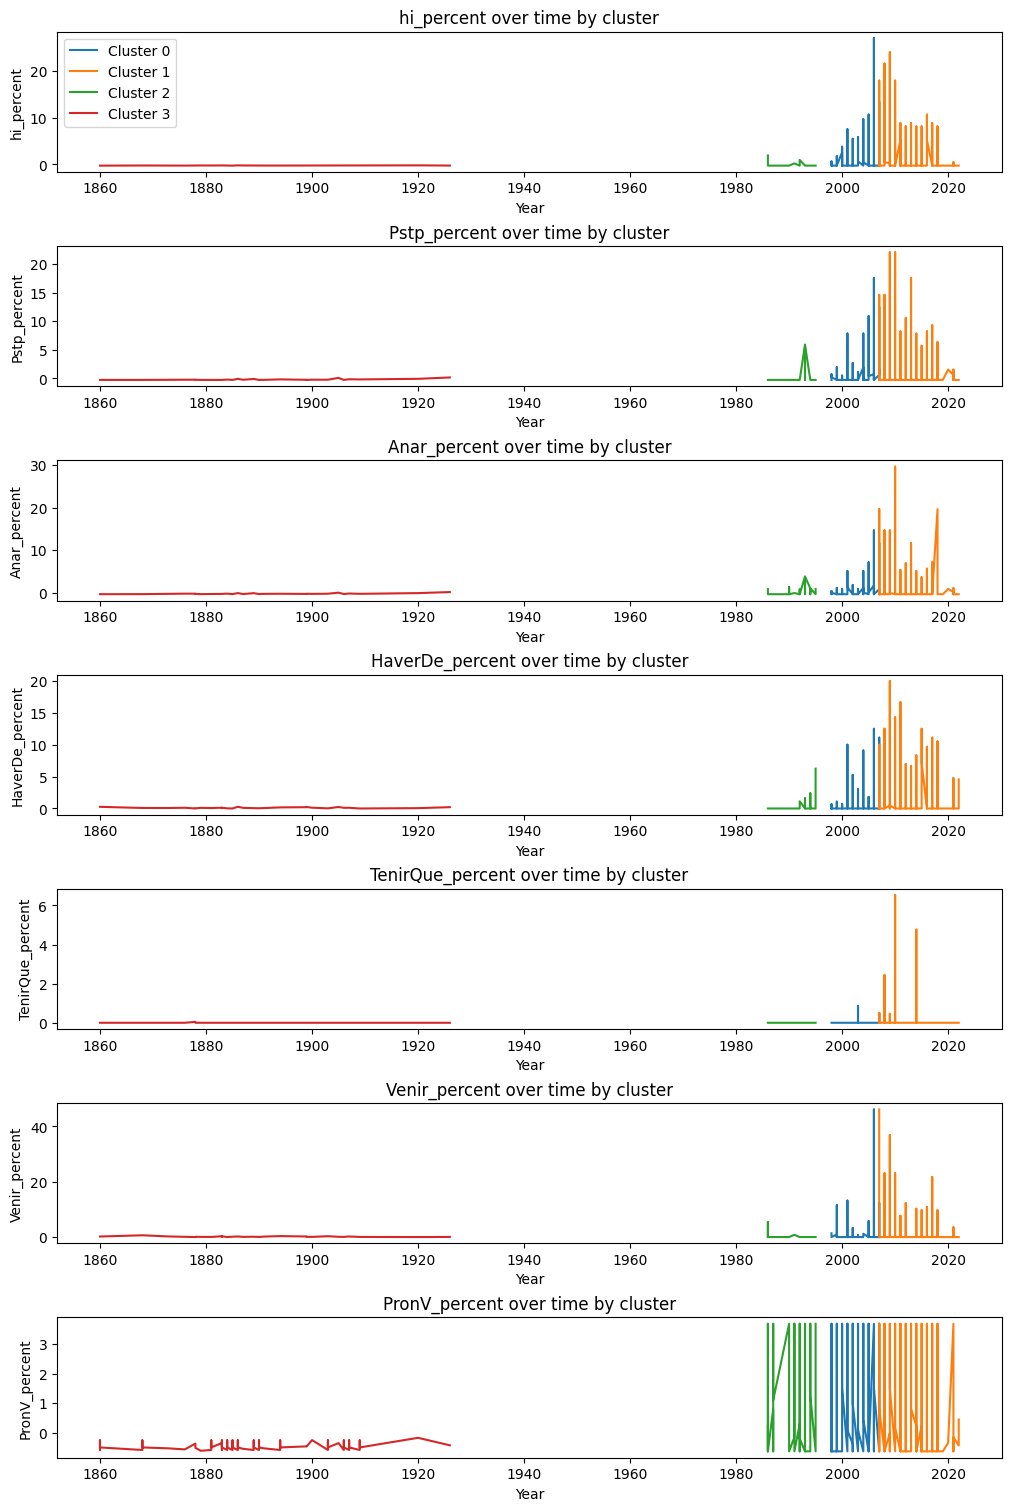

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplot_mosaic([["A", "A"], # A - hi 
                              ["B", "B"], # B - PassatPerifràstic
                              ["C", "C"], # C - venir
                              ["D", "D"], # D - anar
                              ["E", "E"], # E - Haver de
                              ["F", "F"], # F - Tenir que
                              ["G", "G"]], # G - Pronominal Verbs 
                             figsize=(10, 15),
                             constrained_layout=True)

# (A) Clustering of years acording to the percentage of hi respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["A"].plot(subset["Year"], subset["hi_percent"], label=f"Cluster {cluster}")
    
ax["A"].legend()
ax["A"].set_title("hi_percent over time by cluster")
ax["A"].set_xlabel("Year")
ax["A"].set_ylabel("hi_percent")

# (B) Clustering of years acording to the percentage of Passat Perifràstic respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["B"].plot(subset["Year"], subset["Pstp_percent"], label=f"Cluster {cluster}")
    
ax["B"].set_title("Pstp_percent over time by cluster")
ax["B"].set_xlabel("Year")
ax["B"].set_ylabel("Pstp_percent")

# (C) Clustering of years acording to the percentage of Venir respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["C"].plot(subset["Year"], subset["Anar_percent"], label=f"Cluster {cluster}")
    
ax["C"].set_title("Anar_percent over time by cluster")
ax["C"].set_xlabel("Year")
ax["C"].set_ylabel("Anar_percent")

# (D) Clustering of years acording to the percentage of Haver de respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["D"].plot(subset["Year"], subset["HaverDe_percent"], label=f"Cluster {cluster}")
    
ax["D"].set_title("HaverDe_percent over time by cluster")
ax["D"].set_xlabel("Year")
ax["D"].set_ylabel("HaverDe_percent")


# (E) Clustering of years acording to the percentage of Tenir que respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["E"].plot(subset["Year"], subset["TenirQue_percent"], label=f"Cluster {cluster}")
    
ax["E"].set_title("TenirQue_percent over time by cluster")
ax["E"].set_xlabel("Year")
ax["E"].set_ylabel("TenirQue_percent")


# (F) Clustering of years acording to the percentage of Anar respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["F"].plot(subset["Year"], subset["Venir_percent"], label=f"Cluster {cluster}")
    
ax["F"].set_title("Venir_percent over time by cluster")
ax["F"].set_xlabel("Year")
ax["F"].set_ylabel("Venir_percent")

# (G) Clustering of years acording to the percentage of Pronominal Verbs respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["G"].plot(subset["Year"], subset["PronV_percent"], label=f"Cluster {cluster}")
    
ax["G"].set_title("PronV_percent over time by cluster")
ax["G"].set_xlabel("Year")
ax["G"].set_ylabel("PronV_percent")

# displaying
plt.show()

**This is just the placeholder for the conclusion of this part of this analysis. I currently do not have enough knowledge of this method to do anything with these results/plots.**